In [ ]:
!pip install --quiet wandb

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import wandb
from tqdm import tqdm
import numpy as np
import heapq
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import wandb


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m013 (da24m013-iit-madras-alumni-association) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                roman, native = parts[0], parts[1]
                data.append((roman, native))
    return data


train_data = load_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv')
dev_data = load_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv')
test_data = load_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv')

## EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert loaded data into DataFrames
train_df = pd.DataFrame(train_data, columns=['roman', 'native'])
dev_df = pd.DataFrame(dev_data, columns=['roman', 'native'])
test_df = pd.DataFrame(test_data, columns=['roman', 'native'])

# Quick look at the data
print("Train Set Sample:")
print(train_df.head())

print("\nDev Set Sample:")
print(dev_df.head())

print("\nTest Set Sample:")
print(test_df.head())

In [ ]:
# Check dataset sizes
print("\nDataset sizes:")
print(f"Train: {len(train_df)} | Dev: {len(dev_df)} | Test: {len(test_df)}")

# Check for missing values
print("\nMissing values:")
print(train_df.isnull().sum())

In [ ]:

# Check distribution of word lengths in roman and native
train_df['roman_len'] = train_df['roman'].apply(len)
train_df['native_len'] = train_df['native'].apply(len)

# Plot histograms of word lengths
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['roman_len'], bins=20, kde=True, color='skyblue')
plt.title('Length of Romanized Words (Train Set)')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train_df['native_len'], bins=20, kde=True, color='salmon')
plt.title('Length of Native Script Words (Train Set)')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Unique roman and native characters
unique_roman_chars = set(''.join(train_df['roman']))
unique_native_chars = set(''.join(train_df['native']))

print(f"\nUnique Roman characters in train set: {len(unique_roman_chars)} → {sorted(unique_roman_chars)}")
print(f"Unique Native (Telugu) characters in train set: {len(unique_native_chars)} → {sorted(unique_native_chars)}")

## Model Building

In [ ]:

# Set device and optimize GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Speed up training when input sizes don't change

print(f"Using device: {device}")

# --- Improved Data Loading & Preprocessing --- #
def read_data(path):
    """More efficient data loading with proper error handling"""
    try:
        df = pd.read_csv(path, sep='\t', header=None)
        valid_rows = []
        
        for i, row in df.iterrows():
            if len(row) >= 2:
                target, source = row[0], row[1]
                if isinstance(target, str) and isinstance(source, str):
                    valid_rows.append((target.strip(), source.strip()))
                else:
                    print(f"Skipped non-string row at index {i}")
            else:
                print(f"Skipped malformed row at index {i}")
                
        print(f"Loaded {len(valid_rows)} valid rows from {path}")
        return valid_rows
    except Exception as e:
        print(f"Error loading data from {path}: {e}")
        return []

def build_vocab(pairs, idx=0):
    """Build vocabulary dictionaries with special tokens"""
    # Add special tokens
    chars = sorted(set(ch for p in pairs for ch in p[idx] if isinstance(p[idx], str)))
    stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    # Add regular characters
    for i, ch in enumerate(chars):
        stoi[ch] = i + 4  # Start after special tokens
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos

class TransliterationDataset(Dataset):
    def __init__(self, data, input_stoi, target_stoi):
        self.data = data
        self.input_stoi = input_stoi
        self.target_stoi = target_stoi
        
        # Pre-process all data at init time to speed up training
        self.processed_data = []
        for x, y in data:
            try:
                # Handle unknown characters with <unk> token
                x_indices = [self.input_stoi.get(c, self.input_stoi['<unk>']) for c in x]
                y_indices = [self.target_stoi['<sos>']] + [self.target_stoi.get(c, self.target_stoi['<unk>']) for c in y] + [self.target_stoi['<eos>']]
                self.processed_data.append((torch.tensor(x_indices), torch.tensor(y_indices)))
            except Exception as e:
                print(f"Error processing data pair: {x}, {y}. Error: {e}")
                continue

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]

def collate_fn(batch):
    """Efficient batch collation - keep tensors on CPU for pin_memory to work"""
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch  # Return CPU tensors, don't send to device here

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, emb_dim, hid_dim, n_layers, dropout, cell_type='LSTM'):
        super(Seq2Seq, self).__init__()

        # Embedding layers
        self.encoder_embedding = nn.Embedding(input_dim, emb_dim)
        self.decoder_embedding = nn.Embedding(output_dim, emb_dim)

        # Select RNN Cell type dynamically (LSTM / GRU / RNN)
        rnn_cell = getattr(nn, cell_type)

        # Encoder and Decoder RNNs
        self.encoder = rnn_cell(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers, 
                            dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.decoder = rnn_cell(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers, 
                            dropout=dropout if n_layers > 1 else 0, batch_first=True)

        # Linear layer to map decoder hidden state to output vocabulary
        self.fc_out = nn.Linear(hid_dim, output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Store parameters for sanity checks
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.cell_type = cell_type

        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True  # Enable cudnn auto-tuning

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: [batch_size, src_len]
        trg: [batch_size, trg_len]
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        output_dim = self.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, output_dim).to(src.device)

        # Encoder embedding
        embedded_src = self.dropout(self.encoder_embedding(src))  # [batch_size, src_len, emb_dim]

        # Encoder RNN
        _, hidden = self.encoder(embedded_src)

        # First input to decoder is the <sos> token (first token in target sequence)
        input = trg[:, 0]  # [batch_size]

        for t in range(1, trg_len):
            # Decoder embedding for current input
            embedded = self.dropout(self.decoder_embedding(input))  # [batch_size, emb_dim]
            embedded = embedded.unsqueeze(1)  # Add seq_len dimension: [batch_size, 1, emb_dim]

            # Decoder RNN step
            output, hidden = self.decoder(embedded, hidden)  # output: [batch_size, 1, hid_dim]

            # Predict next token
            prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]

            # Store prediction
            outputs[:, t, :] = prediction

            # Decide if using teacher forcing for next step
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            
            # Get top predicted token
            top1 = prediction.argmax(1)  # [batch_size]

            # Next input is either actual next token (teacher forcing) or predicted one
            input = trg[:, t] if teacher_force else top1

        return outputs

    def encode(self, src):
        """Encode the source sequence"""
        # Embed source sequence
        embedded_src = self.encoder_embedding(src)  # [batch_size, src_len, emb_dim]
        
        # Pass through encoder
        _, hidden = self.encoder(embedded_src)
        
        return hidden

    def decode_step(self, input_token, hidden):
        """Decode one step given previous hidden state and current input token"""
        # Embed the input token
        embedded = self.decoder_embedding(input_token)  # [batch_size, 1, emb_dim]
    
        # Run through decoder
        output, hidden = self.decoder(embedded, hidden)  # [batch_size, 1, hidden_dim]
    
        # Project to output vocabulary
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, vocab_size]
    
        return prediction, hidden


# --- Improved Training & Evaluation --- #
def train_one_epoch(model, loader, criterion, optimizer, teacher_forcing_ratio=0.7, device_to_use=None):
    """
    Train the model for one epoch with a fixed teacher forcing ratio
    
    Args:
        model: The Seq2Seq model
        loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        teacher_forcing_ratio: Fixed probability of using teacher forcing (default: 0.7)
        device_to_use: Device to use for training
        
    Returns:
        tuple: Average loss and accuracy for the epoch
    """
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
        
    model.train()
    total_loss, total_correct, total_chars = 0, 0, 0
    
    # Use tqdm for progress monitoring
    pbar = tqdm(loader, desc=f"Training (TF ratio: {teacher_forcing_ratio:.2f})")
    for src, tgt in pbar:
        # Safety check for empty batches or invalid dimensions
        if src.numel() == 0 or tgt.numel() == 0:
            print("Warning: Empty batch detected, skipping")
            continue
            
        try:
            # Move data to device here (after collate_fn)
            src, tgt = src.to(device_to_use), tgt.to(device_to_use)
            
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            # Use the fixed teacher forcing ratio
            output = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio)
            
            # Reshape output and target for loss calculation
            # Output shape: [batch_size, trg_len, output_dim]
            # We need to match this with the target format
            # Target should exclude the first token (SOS)
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            target = tgt[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Calculate accuracy
            with torch.no_grad():
                pred = output.argmax(dim=-1)
                mask = target != 0  # Only count non-padding positions
                if mask.sum().item() > 0:  # Avoid division by zero
                    correct = (pred[mask] == target[mask]).sum().item()
                    chars = mask.sum().item()
                    
                    total_correct += correct
                    total_chars += chars
                    total_loss += loss.item()
                    
                    # Update progress bar with current metrics
                    pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/max(1, chars):.4f}")
                
        except RuntimeError as e:
            print(f"Error in training batch: {e}")
            print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
            # Try to continue with next batch
            continue

    # Avoid division by zero
    avg_loss = total_loss / max(1, len(loader))
    avg_acc = total_correct / max(1, total_chars)
    return avg_loss, avg_acc
def evaluate(model, loader, criterion, device_to_use=None):
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
        
    model.eval()
    total_loss, total_correct, total_chars = 0, 0, 0
    
    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="Evaluating"):
            # Safety check for empty batches
            if src.numel() == 0 or tgt.numel() == 0:
                continue
                
            try:
                # Move data to device here
                src, tgt = src.to(device_to_use), tgt.to(device_to_use)
                
                output = model(src, tgt, teacher_forcing_ratio=0.0)  # No teacher forcing during evaluation
                
                # Reshape for loss calculation
                output_dim = output.shape[-1]
                output = output[:, 1:].contiguous().view(-1, output_dim)
                target = tgt[:, 1:].contiguous().view(-1)
                
                loss = criterion(output, target)
                
                pred = output.argmax(dim=-1)
                mask = target != 0  # Only count non-padding positions
                if mask.sum().item() > 0:  # Avoid division by zero
                    total_correct += (pred[mask] == target[mask]).sum().item()
                    total_chars += mask.sum().item()
                    total_loss += loss.item()
                
            except RuntimeError as e:
                print(f"Error in evaluation batch: {e}")
                continue

    # Avoid division by zero
    avg_loss = total_loss / max(1, len(loader))
    avg_acc = total_correct / max(1, total_chars)
    return avg_loss, avg_acc

# --- Greedy Decoding --- #
def predict_greedy(model, input_str, input_stoi, target_stoi, target_itos, device_to_use=None):
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
        
    model.eval()
    input_indices = [input_stoi.get(c, input_stoi['<unk>']) for c in input_str]
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device_to_use)

    with torch.no_grad():
        output_indices = [target_stoi['<sos>']]
        max_length = 100
        
        hidden = model.encode(input_tensor)
        
        for _ in range(max_length):
            last_token = torch.tensor([[output_indices[-1]]]).to(device_to_use)
            prediction, hidden = model.decode_step(last_token, hidden)
            next_token = prediction.argmax(1).item()
            
            if next_token == target_stoi['<eos>']:
                break
                
            output_indices.append(next_token)

    # Convert indices to characters (skip <sos>)
    predicted_chars = [target_itos.get(i, '<unk>') for i in output_indices[1:]]
    predicted_str = ''.join(predicted_chars).strip()
    
    return predicted_str

# --- Beam Search Implementation --- #
def predict_beam_search(model, input_str, input_stoi, target_stoi, target_itos, beam_size=5, device_to_use=None):
    if device_to_use is None:
        device_to_use = device

    model.eval()
    input_indices = [input_stoi.get(c, input_stoi['<unk>']) for c in input_str]
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device_to_use)

    with torch.no_grad():
        hidden = model.encode(input_tensor)

        sos_token = target_stoi['<sos>']
        eos_token = target_stoi['<eos>']

        beams = [(0.0, [sos_token], hidden)]
        completed_sequences = []
        max_length = min(100, len(input_str) * 2)

        for _ in range(max_length):
            if len(completed_sequences) >= beam_size:
                break

            new_beams = []

            for score, seq, hidden_state in beams:
                if seq[-1] == eos_token:
                    completed_sequences.append((score, seq))
                    continue

                last_token = torch.tensor([[seq[-1]]]).to(device_to_use)
                prediction, new_hidden = model.decode_step(last_token, hidden_state)

                log_probs = torch.log_softmax(prediction.squeeze(0), dim=-1)
                topk_probs, topk_idxs = torch.topk(log_probs, min(beam_size, log_probs.size(-1)))

                for i in range(topk_idxs.size(-1)):
                    prob = topk_probs[i].item()
                    idx = topk_idxs[i].item()

                    new_score = score + prob
                    new_seq = seq + [idx]

                    if idx == eos_token:
                        completed_sequences.append((new_score, new_seq))
                    else:
                        new_beams.append((new_score, new_seq, new_hidden))

            beams = heapq.nlargest(beam_size, new_beams, key=lambda x: x[0])
            if not beams:
                break

        if not completed_sequences:
            if beams:
                best_beam = max(beams, key=lambda x: x[0])
                completed_sequences.append((best_beam[0], best_beam[1]))
            else:
                completed_sequences.append((0.0, [sos_token]))

        best_score, best_seq = max(completed_sequences, key=lambda x: x[0])

        if best_seq[-1] == eos_token:
            best_seq = best_seq[1:-1]
        else:
            best_seq = best_seq[1:]

    # Convert indices back to characters
    predicted_chars = [target_itos.get(i, '<unk>') for i in best_seq]
    predicted_str = ''.join(predicted_chars).strip()   # <-- ✅ this is the critical addition

    return predicted_str

# --- WandB Sweep Training Loop with Meaningful Run Names --- #
def sweep_train(config=None):
    # Initialize wandb with exception handling
    try:
        with wandb.init(config=config) as run:
            config = wandb.config
            
            # Create meaningful name for the run based on config
            # Include the fixed teacher forcing ratio in the run name
            teacher_forcing_ratio = 0.7  # Fixed teacher forcing ratio
            run_name = f"{config.cell_type}-L{config.n_layers}-H{config.hid_dim}-E{config.emb_dim}-D{config.dropout}-B{config.beam_size}-TF{teacher_forcing_ratio}"
            run.name = run_name  # Set the name for WandB run
            
            print(f"Training with config: {config}, TF ratio: {teacher_forcing_ratio}, Run name: {run_name}")
            
            # Create model with better error handling
            try:
                # Make sure input_stoi and target_stoi are defined
                if 'input_stoi' not in globals() or 'target_stoi' not in globals():
                    print("Warning: Vocabularies not defined. Make sure to run the data loading code first.")
                    return
                
                model = Seq2Seq(
                    input_dim=len(input_stoi),
                    output_dim=len(target_stoi),
                    emb_dim=config.emb_dim,
                    hid_dim=config.hid_dim,
                    n_layers=config.n_layers,
                    cell_type=config.cell_type,
                    dropout=config.dropout
                )
                
                # Print model details before moving to GPU
                total_params = sum(p.numel() for p in model.parameters())
                print(f"Model has {total_params:,} parameters")
                
                # IMPORTANT FIX: Always start on CPU first, then try GPU
                # This prevents CUDA errors during model initialization
                model = model.to('cpu')
                device_to_use = torch.device('cpu')
                
                # Try to move to GPU if available
                if torch.cuda.is_available():
                    try:
                        # Set environment variable for better error messages
                        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
                        model = model.to(device)
                        device_to_use = device
                        print("Successfully moved model to GPU")
                    except RuntimeError as e:
                        print(f"CUDA error when moving model to device: {e}")
                        print("Keeping model on CPU")
                
                # Initialize optimizer and loss function
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                # KEY FIX: Use ignore_index=0 to ignore padding in loss computation
                criterion = nn.CrossEntropyLoss(ignore_index=0)
                
                best_val_acc = 0
                best_config = None
                for epoch in range(3):  # 3 epochs
                    print(f"\nEpoch {epoch+1}/3")
                    
                    try:
                        # Use device_to_use instead of global device and pass the fixed teacher forcing ratio
                        train_loss, train_acc = train_one_epoch(
                            model, 
                            train_loader, 
                            criterion, 
                            optimizer, 
                            teacher_forcing_ratio=teacher_forcing_ratio,  # Pass fixed value
                            device_to_use=device_to_use
                        )
                        val_loss, val_acc = evaluate(model, dev_loader, criterion, device_to_use)
                        
                        # Log the teacher forcing ratio along with other metrics
                        wandb.log({
                            "train_loss": train_loss, 
                            "train_acc": train_acc,
                            "val_loss": val_loss, 
                            "val_acc": val_acc,
                            "teacher_forcing_ratio": teacher_forcing_ratio  # Log the TF ratio
                        })
                        
                        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
                        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
                        
                        # Save best model
                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            best_config = dict(config)  # Clone the best config
                            best_config['teacher_forcing_ratio'] = teacher_forcing_ratio  # Add TF ratio to the best config

                    except Exception as e:
                        print(f"Error during epoch {epoch+1}: {e}")
                        import traceback
                        traceback.print_exc()
                        continue
                
                # At end of training
                if best_config:
                    print(f"Best validation accuracy: {best_val_acc:.4f}")
                    print("Best config:")
                    for k, v in best_config.items():
                        print(f"{k}: {v}")

                # Evaluation with beam search (if there was a successful training)
                if best_val_acc > 0 and hasattr(config, 'beam_size') and config.beam_size > 1:
                    print(f"\nEvaluating with beam search (beam size = {config.beam_size})...")
                    
                    # Use a small subset for beam search evaluation to save time
                    num_samples = min(50, len(test_data))
                    beam_search_examples = test_data[:num_samples]
                    
                    # Compare greedy vs beam decoding
                    greedy_correct = 0
                    beam_correct = 0
                    
                    for target, source in tqdm(beam_search_examples):
                        try:
                            greedy_output = predict_greedy(model, source, input_stoi, target_stoi, target_itos, device_to_use)
                            beam_output = predict_beam_search(model, source, input_stoi, target_stoi, target_itos, beam_size=config.beam_size, device_to_use=device_to_use)
                            
                            greedy_correct += 1 if greedy_output.strip() == target.strip() else 0
                            beam_correct   += 1 if beam_output.strip() == target.strip() else 0
                        except Exception as e:
                            print(f"Error during prediction: {e}")
                            continue
                    
                    greedy_acc = greedy_correct / num_samples
                    beam_acc = beam_correct / num_samples
                    
                    wandb.log({
                        "greedy_accuracy": greedy_acc,
                        "beam_search_accuracy": beam_acc
                    })
                    
                    print(f"Greedy Decoding Accuracy: {greedy_acc:.4f}")
                    print(f"Beam Search Accuracy: {beam_acc:.4f}")
            
            except Exception as e:
                print(f"Fatal error during model training: {e}")
                import traceback
                traceback.print_exc()
                
    except Exception as e:
        print(f"Error initializing wandb: {e}")


# --- Main Execution --- #

if __name__ == "__main__":
    # Add debugging for CUDA device initialization
    if torch.cuda.is_available():
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

    # --- Load Data --- #
    print("Loading data...")
    train_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv')
    dev_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv')
    test_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv')

    print(f"Data loaded - Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)}")

    # Build vocab with special tokens
    print("Building vocabulary...")
    input_stoi, input_itos = build_vocab(train_data, idx=1)  # Roman input
    target_stoi, target_itos = build_vocab(train_data, idx=0)  # Telugu output

    print(f"Vocabulary size - Input: {len(input_stoi)}, Target: {len(target_stoi)}")

    # --- Dataset and DataLoader preparation --- #
    print("Preparing datasets...")
    train_ds = TransliterationDataset(train_data, input_stoi, target_stoi)
    dev_ds = TransliterationDataset(dev_data, input_stoi, target_stoi)
    test_ds = TransliterationDataset(test_data, input_stoi, target_stoi)

    # Check if we have valid data
    if len(train_ds) == 0:
        print("Error: No valid training data after processing")
        raise ValueError("Empty dataset")

    # Optimize batch size for better GPU utilization
    # KEY FIX: Reduced batch size to avoid memory issues
    BATCH_SIZE = 32  # Further reduced from 64 to be safer
    # Use pin_memory for faster data loading, but only if using CUDA
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    dev_loader = DataLoader(
        dev_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    # --- Sweep Configuration with Beam Size --- #
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'emb_dim': {'values': [32, 64, 128]},
            'hid_dim': {'values': [64, 128, 256]},
            'n_layers': {'values': [1, 2]},
            'dropout': {'values': [0.2, 0.3]},
            'cell_type': {'values': ['LSTM', 'GRU','RNN']},
            'beam_size': {'values': [1, 3]}
        }
    }

    # --- Run WandB Sweep --- #
    print("Starting WandB sweep...")
    # Reduced count to 5 for initial testing

    sweep_id = wandb.sweep(sweep_config, project="DA6401-A3")
    wandb.agent(sweep_id, function=sweep_train, count=25)  # Start with just 5 runs

In [ ]:
import wandb

# Load best config manually after sweep (fill your values)
best_config = {
    'emb_dim': 64,
    'hid_dim': 256,
    'n_layers': 2,
    'dropout': 0.3,
    'cell_type': 'LSTM'
}

# Combine train and dev data for final training
final_train_data = train_data + dev_data
final_train_ds = TransliterationDataset(final_train_data, input_stoi, target_stoi)
final_train_loader = DataLoader(
    final_train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=pin_memory
)

# Initialize model
final_model = Seq2Seq(
    input_dim=len(input_stoi),
    output_dim=len(target_stoi),
    emb_dim=best_config['emb_dim'],
    hid_dim=best_config['hid_dim'],
    n_layers=best_config['n_layers'],
    dropout=best_config['dropout'],
    cell_type=best_config['cell_type']
).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Initialize wandb run
wandb.init(project="DA6401-A3", name="Test-Run", config=best_config, allow_val_change=True, reinit=True)


# Final training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, final_train_loader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    wandb.log({
        'epoch': epoch+1,
        'train_loss': train_loss,
        'train_acc': train_acc
    })

In [ ]:
import os
import wandb
import pandas as pd
from tqdm import tqdm

# Create predictions folder
os.makedirs("predictions_vanilla", exist_ok=True)
pred_file_path = os.path.join("predictions_vanilla", "test_predictions.txt")

# Start a new WandB run to log predictions
wandb.init(project="DA6401-A3", name="Final-Test-Predictions")

# Final evaluation
final_model.eval()
total, correct = 0, 0
prediction_records = []
print(f"Number of test samples: {len(test_data)}")
with open(pred_file_path, 'w', encoding='utf-8') as f:
    for target, source in test_data:
        beam_size = best_config.get('beam_size', 1)
        if beam_size > 1:
            pred = predict_beam_search(final_model, source, input_stoi, target_stoi, target_itos, beam_size=beam_size)
        else:
            pred = predict_greedy(final_model, source, input_stoi, target_stoi, target_itos)

        # print(f"Source: {source} | Predicted: {pred} | Target: {target}")
        # break


        # Record for both WandB and file
        record = {
            "Input (Romanized)": source,
            "Model Prediction (Telugu)": pred,
            "Reference (Telugu)": target
        }
        prediction_records.append(record)
        if total < 20:
            print(f"Source: {source} | Predicted: {pred} | Target: {target}")


        # Write to file
        f.write(f"{source}\t{pred}\n")

        # Accuracy calculation
        if pred.strip() == target.strip():
            correct += 1
        total += 1

# Compute final test accuracy
test_acc = correct / total
print(f"\nFinal Test Accuracy (Exact Match): {test_acc:.4f}")

# Log final test accuracy
wandb.log({"final_test_accuracy": test_acc})

# Log creative predictions table
pred_df = pd.DataFrame(prediction_records)
wandb_table = wandb.Table(dataframe=pred_df)
wandb.log({"final_test_predictions_table": wandb_table})

wandb.finish()

# Attension

In [3]:

# Set device and optimize GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Speed up training when input sizes don't change

print(f"Using device: {device}")

# --- Improved Data Loading & Preprocessing --- #
def read_data(path):
    """More efficient data loading with proper error handling"""
    try:
        df = pd.read_csv(path, sep='\t', header=None)
        valid_rows = []
        
        for i, row in df.iterrows():
            if len(row) >= 2:
                target, source = row[0], row[1]
                if isinstance(target, str) and isinstance(source, str):
                    valid_rows.append((target.strip(), source.strip()))
                else:
                    print(f"Skipped non-string row at index {i}")
            else:
                print(f"Skipped malformed row at index {i}")
                
        print(f"Loaded {len(valid_rows)} valid rows from {path}")
        return valid_rows
    except Exception as e:
        print(f"Error loading data from {path}: {e}")
        return []

def build_vocab(pairs, idx=0):
    """Build vocabulary dictionaries with special tokens"""
    # Add special tokens
    chars = sorted(set(ch for p in pairs for ch in p[idx] if isinstance(p[idx], str)))
    stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    # Add regular characters
    for i, ch in enumerate(chars):
        stoi[ch] = i + 4  # Start after special tokens
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos

class TransliterationDataset(Dataset):
    def __init__(self, data, input_stoi, target_stoi):
        self.data = data
        self.input_stoi = input_stoi
        self.target_stoi = target_stoi
        
        # Pre-process all data at init time to speed up training
        self.processed_data = []
        for x, y in data:
            try:
                # Handle unknown characters with <unk> token
                x_indices = [self.input_stoi.get(c, self.input_stoi['<unk>']) for c in x]
                y_indices = [self.target_stoi['<sos>']] + [self.target_stoi.get(c, self.target_stoi['<unk>']) for c in y] + [self.target_stoi['<eos>']]
                self.processed_data.append((torch.tensor(x_indices), torch.tensor(y_indices)))
            except Exception as e:
                print(f"Error processing data pair: {x}, {y}. Error: {e}")
                continue

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]

def collate_fn(batch):
    """Efficient batch collation - keep tensors on CPU for pin_memory to work"""
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch  # Return CPU tensors, don't send to device here
# First, let's import the missing F module that we use in the attention class
import torch.nn.functional as F

# Fixed implementation of the Attention class
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Parameter(torch.rand(dec_hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # Check dimensions of hidden and handle appropriately
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Fix: Check if hidden has 3 dimensions [n_layers, batch, hidden_dim]
        if hidden.dim() == 3:
            hidden = hidden[-1]  # Use only the last layer: [batch_size, dec_hidden_dim]
            
        # Now reshape hidden for attention calculation
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch, src_len, dec_hidden_dim]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch, src_len, dec_hidden_dim] 
        energy = energy.permute(0, 2, 1)  # [batch, dec_hidden_dim, src_len]
        
        # Fix: Make sure v has the correct batch dimension
        v = self.v.unsqueeze(0).repeat(batch_size, 1).unsqueeze(1)  # [batch, 1, dec_hidden_dim]

        attention = torch.bmm(v, energy).squeeze(1)  # [batch, src_len]
        return F.softmax(attention, dim=1)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [batch, src_len, emb_dim]
        outputs, hidden = self.rnn(embedded)           # outputs: [batch, src_len, hid_dim]
        return outputs, hidden
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim + emb_dim, dec_hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input))  # [batch, 1, emb_dim]

        # Attention
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # [batch, src_len]
        attn_weights = attn_weights.unsqueeze(1)  # [batch, 1, src_len]
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, enc_hid_dim]

        # RNN input
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch, 1, emb_dim + enc_hid_dim]
        output, hidden = self.rnn(rnn_input, hidden)  # output: [batch, 1, dec_hid_dim]

        # Output prediction
        output = output.squeeze(1)
        context = context.squeeze(1)
        embedded = embedded.squeeze(1)

        pred = self.fc_out(torch.cat((output, context, embedded), dim=1))  # [batch, output_dim]
        return pred, hidden

class Seq2Seq_atten(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        input_token = tgt[:, 0]  # <sos>

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = tgt[:, t] if teacher_force else top1

        return outputs

    def encode(self, src):
        """Get encoder outputs and hidden state"""
        encoder_outputs, hidden = self.encoder(src)
        return encoder_outputs, hidden  # Return both outputs and hidden state

    def decode_step(self, input_token, encoder_state):
        """Perform one decoding step"""
        # Unpack encoder state into outputs and hidden
        encoder_outputs, hidden = encoder_state
        
        # Perform decoder step
        output, hidden = self.decoder(input_token.squeeze(1), hidden, encoder_outputs)
        
        # Return output and new state (which includes both outputs and hidden)
        return output, (encoder_outputs, hidden)



# --- Improved Training & Evaluation --- #
def train_one_epoch(model, loader, criterion, optimizer, teacher_forcing_ratio=0.7, device_to_use=None):
    """
    Train the model for one epoch with a fixed teacher forcing ratio
    
    Args:
        model: The Seq2Seq model
        loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        teacher_forcing_ratio: Fixed probability of using teacher forcing (default: 0.7)
        device_to_use: Device to use for training
        
    Returns:
        tuple: Average loss and accuracy for the epoch
    """
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
        
    # Ensure the model is on the correct device
    model = model.to(device_to_use)
    model.train()
    total_loss, total_correct, total_chars = 0, 0, 0
    
    # Use tqdm for progress monitoring
    pbar = tqdm(loader, desc=f"Training (TF ratio: {teacher_forcing_ratio:.2f})")
    for src, tgt in pbar:
        # Safety check for empty batches or invalid dimensions
        if src.numel() == 0 or tgt.numel() == 0:
            print("Warning: Empty batch detected, skipping")
            continue
            
        try:
            # Make sure to move data to the correct device
            src = src.to(device_to_use)
            tgt = tgt.to(device_to_use)
            
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            # Use the fixed teacher forcing ratio
            output = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio)
            
            # Reshape output and target for loss calculation
            # Output shape: [batch_size, trg_len, output_dim]
            # We need to match this with the target format
            # Target should exclude the first token (SOS)
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            target = tgt[:, 1:].contiguous().view(-1)
            
            # Double check that both are on the same device
            if output.device != target.device:
                print(f"Device mismatch: output on {output.device}, target on {target.device}")
                target = target.to(output.device)
            
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Calculate accuracy
            with torch.no_grad():
                pred = output.argmax(dim=-1)
                mask = target != 0  # Only count non-padding positions
                if mask.sum().item() > 0:  # Avoid division by zero
                    correct = (pred[mask] == target[mask]).sum().item()
                    chars = mask.sum().item()
                    
                    total_correct += correct
                    total_chars += chars
                    total_loss += loss.item()
                    
                    # Update progress bar with current metrics
                    pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/max(1, chars):.4f}")
                
        except RuntimeError as e:
            print(f"Error in training batch: {e}")
            print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
            print(f"src device: {src.device}, tgt device: {tgt.device}")
            
            # Try to recover by moving tensors to the correct device
            try:
                if isinstance(src, torch.Tensor) and isinstance(tgt, torch.Tensor):
                    src = src.to(device_to_use)
                    tgt = tgt.to(device_to_use)
                    print(f"Moved tensors to {device_to_use}. Continuing...")
                else:
                    print("Cannot move tensors, skipping batch")
            except:
                print("Recovery failed, skipping batch")
                
            # Try to continue with next batch
            continue

    # Avoid division by zero
    avg_loss = total_loss / max(1, len(loader))
    avg_acc = total_correct / max(1, total_chars)
    return avg_loss, avg_acc

def evaluate(model, loader, criterion, device_to_use=None):
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
    
    # Ensure the model is on the correct device
    model = model.to(device_to_use)    
    model.eval()
    total_loss, total_correct, total_chars = 0, 0, 0
    
    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="Evaluating"):
            # Safety check for empty batches
            if src.numel() == 0 or tgt.numel() == 0:
                continue
                
            try:
                # Move data to device here
                src = src.to(device_to_use)
                tgt = tgt.to(device_to_use)
                
                output = model(src, tgt, teacher_forcing_ratio=0.0)  # No teacher forcing during evaluation
                
                # Reshape for loss calculation
                output_dim = output.shape[-1]
                output = output[:, 1:].contiguous().view(-1, output_dim)
                target = tgt[:, 1:].contiguous().view(-1)
                
                # Double check device match
                if output.device != target.device:
                    target = target.to(output.device)
                
                loss = criterion(output, target)
                
                pred = output.argmax(dim=-1)
                mask = target != 0  # Only count non-padding positions
                if mask.sum().item() > 0:  # Avoid division by zero
                    total_correct += (pred[mask] == target[mask]).sum().item()
                    total_chars += mask.sum().item()
                    total_loss += loss.item()
                
            except RuntimeError as e:
                print(f"Error in evaluation batch: {e}")
                print(f"src device: {src.device}, tgt device: {tgt.device}")
                continue

    # Avoid division by zero
    avg_loss = total_loss / max(1, len(loader))
    avg_acc = total_correct / max(1, total_chars)
    return avg_loss, avg_acc

def predict_greedy(model, input_str, input_stoi, target_stoi, target_itos, device_to_use=None):
    if device_to_use is None:
        device_to_use = device  # Fall back to global device
    
    # Ensure the model is on the correct device
    model = model.to(device_to_use)    
    model.eval()
    input_indices = [input_stoi.get(c, input_stoi['<unk>']) for c in input_str]
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device_to_use)

    with torch.no_grad():
        output_indices = [target_stoi['<sos>']]
        max_length = 100
        
        # Encode the input
        encoder_state = model.encode(input_tensor)
        
        for _ in range(max_length):
            last_token = torch.tensor([[output_indices[-1]]]).to(device_to_use)
            prediction, encoder_state = model.decode_step(last_token, encoder_state)
            next_token = prediction.argmax(1).item()
            
            if next_token == target_stoi['<eos>']:
                break
                
            output_indices.append(next_token)

    # Convert indices to characters (skip <sos>)
    predicted_chars = [target_itos.get(i, '<unk>') for i in output_indices[1:]]
    predicted_str = ''.join(predicted_chars).strip()
    
    return predicted_str

def predict_beam_search(model, input_str, input_stoi, target_stoi, target_itos, beam_size=5, device_to_use=None):
    if device_to_use is None:
        device_to_use = device  # Fall back to global device

    # Ensure the model is on the correct device
    model = model.to(device_to_use)
    model.eval()
    input_indices = [input_stoi.get(c, input_stoi['<unk>']) for c in input_str]
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device_to_use)

    with torch.no_grad():
        # Encode the input sequence once
        encoder_state = model.encode(input_tensor)

        sos_token = target_stoi['<sos>']
        eos_token = target_stoi['<eos>']

        # Initialize beams with the encoder state
        beams = [(0.0, [sos_token], encoder_state)]
        completed_sequences = []
        max_length = min(100, len(input_str) * 2)

        for _ in range(max_length):
            if len(completed_sequences) >= beam_size:
                break

            new_beams = []

            for score, seq, current_state in beams:
                if seq[-1] == eos_token:
                    completed_sequences.append((score, seq))
                    continue

                last_token = torch.tensor([[seq[-1]]]).to(device_to_use)
                prediction, new_state = model.decode_step(last_token, current_state)

                log_probs = torch.log_softmax(prediction.squeeze(0), dim=-1)
                topk_probs, topk_idxs = torch.topk(log_probs, min(beam_size, log_probs.size(-1)))

                for i in range(topk_idxs.size(-1)):
                    prob = topk_probs[i].item()
                    idx = topk_idxs[i].item()

                    new_score = score + prob
                    new_seq = seq + [idx]

                    if idx == eos_token:
                        completed_sequences.append((new_score, new_seq))
                    else:
                        new_beams.append((new_score, new_seq, new_state))

            beams = heapq.nlargest(beam_size, new_beams, key=lambda x: x[0])
            if not beams:
                break

        if not completed_sequences:
            if beams:
                best_beam = max(beams, key=lambda x: x[0])
                completed_sequences.append((best_beam[0], best_beam[1]))
            else:
                completed_sequences.append((0.0, [sos_token]))

        best_score, best_seq = max(completed_sequences, key=lambda x: x[0])

        if best_seq[-1] == eos_token:
            best_seq = best_seq[1:-1]
        else:
            best_seq = best_seq[1:]

    # Convert indices back to characters
    predicted_chars = [target_itos.get(i, '<unk>') for i in best_seq]
    predicted_str = ''.join(predicted_chars).strip() 

    return predicted_str
# --- WandB Sweep Training Loop with Meaningful Run Names --- #
def sweep_train(config=None):
    # Initialize wandb with exception handling
    try:
        with wandb.init(config=config) as run:
            config = wandb.config
            
            # Create meaningful name for the run based on config
            # Include the fixed teacher forcing ratio in the run name
            teacher_forcing_ratio = 0.7  # Fixed teacher forcing ratio
            run_name = f"{config.cell_type}-L{config.n_layers}-H{config.hid_dim}-E{config.emb_dim}-D{config.dropout}-B{config.beam_size}-TF{teacher_forcing_ratio}"
            run.name = run_name  # Set the name for WandB run
            
            print(f"Training with config: {config}, TF ratio: {teacher_forcing_ratio}, Run name: {run_name}")
            
            # Determine device to use first, so we can create models on it directly
            device_to_use = torch.device('cpu')
            if torch.cuda.is_available():
                try:
                    device_to_use = torch.device('cuda')
                    # Set environment variable for better error messages
                    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
                    print(f"Using device: {device_to_use}")
                except RuntimeError as e:
                    print(f"CUDA error when setting device: {e}")
                    print("Falling back to CPU")
                    device_to_use = torch.device('cpu')
            
            # Create model with better error handling
            try:
                # Make sure input_stoi and target_stoi are defined
                if 'input_stoi' not in globals() or 'target_stoi' not in globals():
                    print("Warning: Vocabularies not defined. Make sure to run the data loading code first.")
                    return
                
                # First create encoder and decoder separately, already on the target device
                encoder = Encoder(
                    input_dim=len(input_stoi),
                    emb_dim=config.emb_dim,
                    hid_dim=config.hid_dim,
                    n_layers=config.n_layers,
                    dropout=config.dropout
                ).to(device_to_use)
                
                # Create attention mechanism
                attention = Attention(
                    enc_hidden_dim=config.hid_dim,
                    dec_hidden_dim=config.hid_dim
                ).to(device_to_use)
                
                # Create decoder
                decoder = Decoder(
                    output_dim=len(target_stoi),
                    emb_dim=config.emb_dim,
                    enc_hid_dim=config.hid_dim,
                    dec_hid_dim=config.hid_dim,
                    n_layers=config.n_layers,
                    dropout=config.dropout,
                    attention=attention
                ).to(device_to_use)
                
                # Now create the Seq2Seq model with encoder and decoder
                model = Seq2Seq_atten(
                    encoder=encoder,
                    decoder=decoder,
                    device=device_to_use  # Use the device we determined earlier
                ).to(device_to_use)  # Explicitly move the model to the device
                
                # Print model details
                total_params = sum(p.numel() for p in model.parameters())
                print(f"Model has {total_params:,} parameters")
                print(f"Model is on device: {next(model.parameters()).device}")
                
                # Initialize optimizer and loss function
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss(ignore_index=0)
                criterion = criterion.to(device_to_use)  # Move criterion to device as well
                
                best_val_acc = 0
                best_config = None
                for epoch in range(3):  # 3 epochs
                    print(f"\nEpoch {epoch+1}/3")
                    
                    try:
                        # Use device_to_use for all operations
                        train_loss, train_acc = train_one_epoch(
                            model, 
                            train_loader, 
                            criterion, 
                            optimizer, 
                            teacher_forcing_ratio=teacher_forcing_ratio,
                            device_to_use=device_to_use
                        )
                        val_loss, val_acc = evaluate(model, dev_loader, criterion, device_to_use)
                        
                        # Log the teacher forcing ratio along with other metrics
                        wandb.log({
                            "train_loss": train_loss, 
                            "train_acc": train_acc,
                            "val_loss": val_loss, 
                            "val_acc": val_acc,
                            "teacher_forcing_ratio": teacher_forcing_ratio
                        })
                        
                        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
                        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
                        
                        # Save best model
                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            best_config = dict(config)  # Clone the best config
                            best_config['teacher_forcing_ratio'] = teacher_forcing_ratio  # Add TF ratio to the best config

                    except Exception as e:
                        print(f"Error during epoch {epoch+1}: {e}")
                        import traceback
                        traceback.print_exc()
                        continue
                
                # At end of training
                if best_config:
                    print(f"Best validation accuracy: {best_val_acc:.4f}")
                    print("Best config:")
                    for k, v in best_config.items():
                        print(f"{k}: {v}")

                # Evaluation with beam search (if there was a successful training)
                if best_val_acc > 0 and hasattr(config, 'beam_size') and config.beam_size > 1:
                    print(f"\nEvaluating with beam search (beam size = {config.beam_size})...")
                    
                    # Use a small subset for beam search evaluation to save time
                    num_samples = min(50, len(test_data))
                    beam_search_examples = test_data[:num_samples]
                    
                    # Compare greedy vs beam decoding
                    greedy_correct = 0
                    beam_correct = 0
                    
                    for target, source in tqdm(beam_search_examples):
                        try:
                            greedy_output = predict_greedy(model, source, input_stoi, target_stoi, target_itos, device_to_use)
                            beam_output = predict_beam_search(model, source, input_stoi, target_stoi, target_itos, beam_size=config.beam_size, device_to_use=device_to_use)
                            
                            greedy_correct += 1 if greedy_output.strip() == target.strip() else 0
                            beam_correct   += 1 if beam_output.strip() == target.strip() else 0
                        except Exception as e:
                            print(f"Error during prediction: {e}")
                            continue
                    
                    greedy_acc = greedy_correct / num_samples
                    beam_acc = beam_correct / num_samples
                    
                    wandb.log({
                        "greedy_accuracy": greedy_acc,
                        "beam_search_accuracy": beam_acc
                    })
                    
                    print(f"Greedy Decoding Accuracy: {greedy_acc:.4f}")
                    print(f"Beam Search Accuracy: {beam_acc:.4f}")
            
            except Exception as e:
                print(f"Fatal error during model training: {e}")
                import traceback
                traceback.print_exc()
                
    except Exception as e:
        print(f"Error initializing wandb: {e}")
# --- Main Execution --- #

if __name__ == "__main__":
    # Add debugging for CUDA device initialization
    if torch.cuda.is_available():
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

    # --- Load Data --- #
    print("Loading data...")
    train_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv')
    dev_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv')
    test_data = read_data('/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv')

    print(f"Data loaded - Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)}")

    # Build vocab with special tokens
    print("Building vocabulary...")
    input_stoi, input_itos = build_vocab(train_data, idx=1)  # Roman input
    target_stoi, target_itos = build_vocab(train_data, idx=0)  # Telugu output

    print(f"Vocabulary size - Input: {len(input_stoi)}, Target: {len(target_stoi)}")

    # --- Dataset and DataLoader preparation --- #
    print("Preparing datasets...")
    train_ds = TransliterationDataset(train_data, input_stoi, target_stoi)
    dev_ds = TransliterationDataset(dev_data, input_stoi, target_stoi)
    test_ds = TransliterationDataset(test_data, input_stoi, target_stoi)

    # Check if we have valid data
    if len(train_ds) == 0:
        print("Error: No valid training data after processing")
        raise ValueError("Empty dataset")

    # Optimize batch size for better GPU utilization
    # KEY FIX: Reduced batch size to avoid memory issues
    BATCH_SIZE = 32  # Further reduced from 64 to be safer
    # Use pin_memory for faster data loading, but only if using CUDA
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    dev_loader = DataLoader(
        dev_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_ds, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        pin_memory=pin_memory
    )

    # --- Sweep Configuration with Beam Size --- #
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'emb_dim': {'values': [32, 64, 128]},
            'hid_dim': {'values': [64, 128, 256]},
            'n_layers': {'values': [1, 2]},
            'dropout': {'values': [0.2, 0.3]},
            'cell_type': {'values': ['LSTM', 'GRU','RNN']},
            'beam_size': {'values': [1, 3]}
        }
    }

    # --- Run WandB Sweep --- #
    # print("Starting WandB sweep...")
    # # Reduced count to 5 for initial testing

    # sweep_id = wandb.sweep(sweep_config, project="DA6401-A3")
    # wandb.agent(sweep_id, function=sweep_train, count=25)  # Start with just 5 runs

Using device: cuda
CUDA device count: 2
Current CUDA device: 0
CUDA device name: Tesla T4
Loading data...
Skipped non-string row at index 26313
Loaded 58549 valid rows from /kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Loaded 5683 valid rows from /kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Loaded 5747 valid rows from /kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Data loaded - Train: 58549, Dev: 5683, Test: 5747
Building vocabulary...
Vocabulary size - Input: 30, Target: 67
Preparing datasets...


In [5]:
wandb.init(project="DA6401A3", name="GRU-with-attention")

In [6]:

# Load best config manually after sweep
config = {
    'emb_dim': 32,
    'hid_dim': 64,
    'n_layers': 1,
    'dropout': 0.3,
    'cell_type': 'GRU',
    'batch_size': 64,
    'epochs': 10,
    'learning_rate': 0.001,
    'teacher_forcing_ratio': 0.5
}

wandb.config.update(config)

# Paths
DATA_PATH = "/kaggle/input/dl-agn3/dakshina_dataset_v1.0/te/lexicons"

# Read files
train_df = pd.read_csv(os.path.join(DATA_PATH, "te.translit.sampled.train.tsv"), sep='\t', names=["roman", "native"])
val_df = pd.read_csv(os.path.join(DATA_PATH, "te.translit.sampled.dev.tsv"), sep='\t', names=["roman", "native"])
test_df = pd.read_csv(os.path.join(DATA_PATH, "te.translit.sampled.test.tsv"), sep='\t', names=["roman", "native"])

train_df['roman'] = train_df['roman'].astype(str)
train_df['native'] = train_df['native'].astype(str)

test_df['roman'] = test_df['roman'].astype(str)
test_df['native'] = test_df['native'].astype(str)

val_df['roman'] = val_df['roman'].astype(str)
val_df['native'] = val_df['native'].astype(str)


# Create character vocabularies
def build_vocab(sequences):
    chars = set()
    for seq in sequences:
        if isinstance(seq, str):  # only process if it’s a string
            chars.update(list(seq))
    return ['<pad>', '<sos>', '<eos>', '<unk>'] + sorted(list(chars))


input_vocab = build_vocab(train_df['roman'])
output_vocab = build_vocab(train_df['native'])


input2idx = {ch: idx for idx, ch in enumerate(input_vocab)}
idx2input = {idx: ch for ch, idx in input2idx.items()}
output2idx = {ch: idx for idx, ch in enumerate(output_vocab)}
idx2output = {idx: ch for ch, idx in output2idx.items()}

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

# Dataset class
class TransliterationDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def encode_seq(self, seq, vocab):
        return [vocab.get(c, UNK_IDX) for c in seq]

    def __getitem__(self, idx):
        x = [SOS_IDX] + self.encode_seq(self.data.iloc[idx]['roman'], input2idx) + [EOS_IDX]
        y = [SOS_IDX] + self.encode_seq(self.data.iloc[idx]['native'], output2idx) + [EOS_IDX]
        return torch.tensor(x), torch.tensor(y)

def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    x_lens = [len(x) for x in x_batch]
    y_lens = [len(y) for y in y_batch]
    x_padded = nn.utils.rnn.pad_sequence(x_batch, padding_value=PAD_IDX)
    y_padded = nn.utils.rnn.pad_sequence(y_batch, padding_value=PAD_IDX)
    return x_padded, y_padded, x_lens, y_lens

# DataLoaders
train_loader = DataLoader(TransliterationDataset(train_df), batch_size=config['batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(TransliterationDataset(test_df), batch_size=1, shuffle=False, collate_fn=collate_fn)



In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs, mask):
        seq_len = encoder_outputs.shape[0]
        hidden = hidden.repeat(seq_len, 1, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(1, 0, 2)
        v = self.v.repeat(encoder_outputs.size(1), 1).unsqueeze(1)
        energy = torch.bmm(v, energy.permute(0, 2, 1)).squeeze(1)
        energy.masked_fill_(mask == 0, -1e10)
        return torch.softmax(energy, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.attention = attention
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        attn_weights = self.attention(hidden, encoder_outputs, mask)
        attn_weights = attn_weights.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        context = torch.bmm(attn_weights, encoder_outputs).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = torch.cat((embedded.squeeze(0), output.squeeze(0), context.squeeze(0)), dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden, attn_weights.squeeze(1)


In [ ]:
def create_mask(src):
    return (src != PAD_IDX).permute(1, 0)

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for src, trg, src_len, trg_len in tqdm(iterator):
        src, trg = src.cuda(), trg.cuda()
        optimizer.zero_grad()
        mask = create_mask(src).cuda()
        
        encoder_outputs, hidden = model.encoder(src, src_len)
        
        input_char = torch.tensor([SOS_IDX]*src.size(1)).cuda()
        outputs = torch.zeros(trg.size(0), trg.size(1), len(output_vocab)).cuda()
        
        for t in range(1, trg.size(0)):
            output, hidden, _ = model.decoder(input_char, hidden, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < config['teacher_forcing_ratio']
            top1 = output.argmax(1)
            input_char = trg[t] if teacher_force else top1
        
        outputs_dim = outputs[1:].reshape(-1, outputs.shape[-1])
        trg_dim = trg[1:].reshape(-1)
        loss = criterion(outputs_dim, trg_dim)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg, src_len, trg_len in iterator:
            src, trg = src.cuda(), trg.cuda()
            mask = create_mask(src).cuda()
            encoder_outputs, hidden = model.encoder(src, src_len)
            input_char = torch.tensor([SOS_IDX]*src.size(1)).cuda()
            outputs = torch.zeros(trg.size(0), trg.size(1), len(output_vocab)).cuda()
            
            for t in range(1, trg.size(0)):
                output, hidden, _ = model.decoder(input_char, hidden, encoder_outputs, mask)
                outputs[t] = output
                input_char = output.argmax(1)
                
            outputs_dim = outputs[1:].reshape(-1, outputs.shape[-1])
            trg_dim = trg[1:].reshape(-1)
            loss = criterion(outputs_dim, trg_dim)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, src_len):
        pass  # we use separate train/eval functions


In [ ]:
attn = Attention(config['hid_dim'])
encoder = Encoder(len(input_vocab), config['emb_dim'], config['hid_dim'], config['dropout'])
decoder = Decoder(len(output_vocab), config['emb_dim'], config['hid_dim'], config['dropout'], attn)
model = Seq2Seq(encoder, decoder).cuda()

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


In [ ]:
best_loss = float('inf')
for epoch in range(config['epochs']):
    train_loss = train(model, train_loader, optimizer, criterion, 1)
    val_loss = evaluate(model, test_loader, criterion)
    wandb.log({'train_loss': train_loss, 'val_loss': val_loss})
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Val Loss = {val_loss:.3f}")


In [ ]:
torch.save(model.state_dict(), 'seq2seq_model.pth')


In [ ]:
os.makedirs('predictions_attention', exist_ok=True)
wandb_table = wandb.Table(columns=["Input Roman", "Target Native", "Prediction", "Attention Heatmap"])

def predict_and_save_attention(model, loader, num_samples=10):
    model.eval()
    all_preds, all_targets, all_inputs = [], [], []
    with torch.no_grad():
        samples_done = 0
        for src, trg, src_len, trg_len in loader:
            src, trg = src.cuda(), trg.cuda()
            mask = create_mask(src).cuda()
            encoder_outputs, hidden = model.encoder(src, src_len)
            input_char = torch.tensor([SOS_IDX]).cuda()
            decoded_indices = []
            attentions = []
            for _ in range(30):
                output, hidden, attn_weights = model.decoder(input_char, hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                decoded_indices.append(top1.item())
                attentions.append(attn_weights.cpu().numpy()[0])
                input_char = top1
                if top1.item() == EOS_IDX:
                    break

            pred = ''.join([idx2output[idx] for idx in decoded_indices if idx != EOS_IDX])
            tgt = ''.join([idx2output[idx.item()] for idx in trg[1:] if idx.item() not in [EOS_IDX, PAD_IDX]])
            input_roman = ''.join([idx2input[idx.item()] for idx in src[:, 0] if idx.item() not in [SOS_IDX, EOS_IDX, PAD_IDX]])

            all_preds.append(pred)
            all_targets.append(tgt)
            all_inputs.append(input_roman)

            with open(f'predictions_attention/{samples_done}.txt', 'w') as f:
                f.write(f"Input: {input_roman}\nPrediction: {pred}\nTarget: {tgt}\n")

            if samples_done < num_samples:
                sns.heatmap(np.array(attentions[:len(decoded_indices)]), cmap='viridis')
                plt.title(f"Sample {samples_done}: {pred} vs {tgt}")
                plt.xlabel("Input Characters")
                plt.ylabel("Decoder Steps")
                plt.savefig(f"predictions_attention/attention_{samples_done}.png")
                plt.close()

            wandb_table.add_data(
                input_roman,
                tgt,
                pred,
                wandb.Image(f"predictions_attention/attention_{samples_done}.png") if samples_done < num_samples else None
            )

            samples_done += 1
            if samples_done == len(loader):
                break

    # Write combined predictions file
    with open('predictions_attention/predictions.txt', 'w') as f:
        for i, (inp, pred, tgt) in enumerate(zip(all_inputs, all_preds, all_targets)):
            f.write(f"Sample {i}:\n")
            f.write(f"Input: {inp}\n")
            f.write(f"Prediction: {pred}\n")
            f.write(f"Target: {tgt}\n\n")

    # Compute and print test accuracy
    correct = sum([p == t for p, t in zip(all_preds, all_targets)])
    acc = correct / len(all_preds) * 100
    print(f"Test Accuracy: {acc:.2f}%")

    # Log to wandb
    wandb.log({
        "Test Accuracy": acc,
        "Predictions Table": wandb_table
    })

# Run it
predict_and_save_attention(model, test_loader, num_samples=10)


# Question 6

In [7]:
class EncoderGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.hidden_states = None  # <-- store activations

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))  # [src_len, batch_size, emb_dim]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len, enforce_sorted=False)
        packed_outputs, hidden = self.gru(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)  # [src_len, batch_size, hid_dim]

        self.hidden_states = outputs.detach().cpu()  # Save activations
        return outputs, hidden


In [8]:
# Pick a test example
sample = test_df.iloc[0]['roman']
print("Sample input:", sample)

def encode_sample(seq):
    encoded = [SOS_IDX] + [input2idx.get(c, UNK_IDX) for c in seq] + [EOS_IDX]
    return torch.tensor(encoded).unsqueeze(1)  # [seq_len, 1]

sample_tensor = encode_sample(sample)
sample_len = [sample_tensor.shape[0]]


Sample input: amkamlo


In [9]:
# Instantiate model (ensure you load trained weights here if available)
encoder = EncoderGRU(input_dim=len(input_vocab),
                     emb_dim=config['emb_dim'],
                     hid_dim=config['hid_dim'],
                     n_layers=config['n_layers'],
                     dropout=config['dropout'])

encoder.eval()

with torch.no_grad():
    _ = encoder(sample_tensor, sample_len)
    activations = encoder.hidden_states.squeeze(1)  # [seq_len, hid_dim]


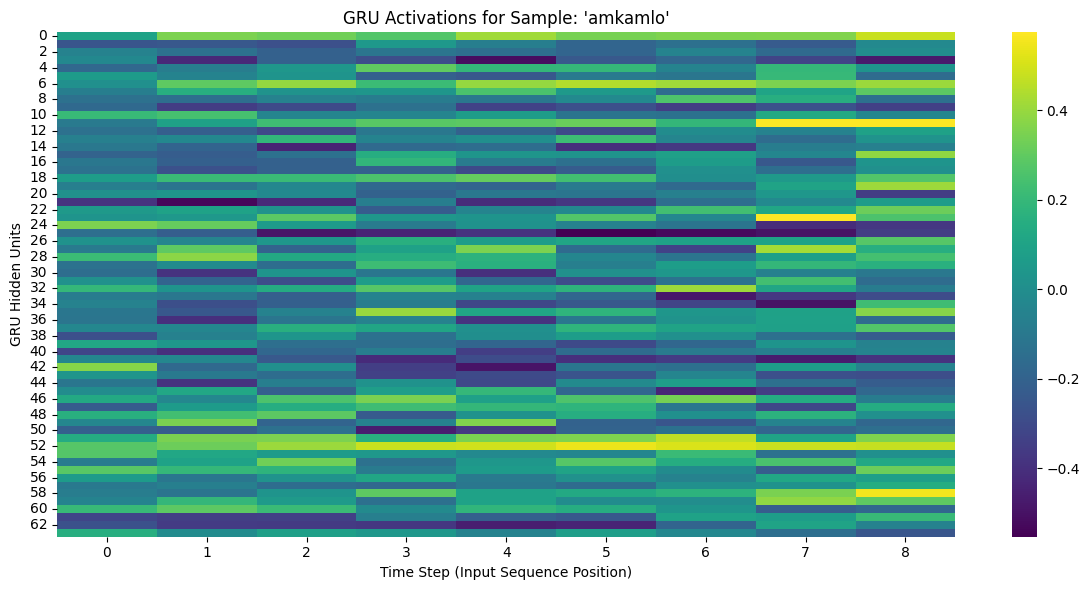

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# Initialize wandb if not already
wandb.init(project="transliteration-activations")

plt.figure(figsize=(12, 6))
sns.heatmap(activations.T, cmap="viridis", cbar=True)
plt.xlabel("Time Step (Input Sequence Position)")
plt.ylabel("GRU Hidden Units")
plt.title(f"GRU Activations for Sample: '{sample}'")
plt.tight_layout()

# Save locally and log to wandb
img_path = "gru_activations.png"
plt.savefig(img_path)
wandb.log({"GRU Activations": wandb.Image(img_path)})
plt.show()
